In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn import linear_model
from sklearn import metrics, model_selection
from sklearn.preprocessing import StandardScaler

In [2]:
# Choose a target
target = "NR-AR"

# import the processed dataset for algorithms what require scaled variables
print('Load Pickle')
pickle_in = open(target + "_processeddata.pkl", "rb")
[param, train_smi, test_smi, train_mol_id, test_mol_id,  X_train, X_test, y_train, y_test] = pickle.load(pickle_in)
pickle_in.close()
print('Finished')

# standardization
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Load Pickle
Finished


We fit the train data using logarithmic regression in the full feature space. **Here, we use class_weight to try to deal with the imbalanced data set.

In [3]:
# create a fit using the logistic regressor (l2) provided in sklearn
log_fit = linear_model.LogisticRegression(class_weight='balanced',max_iter=1000)
log_fit.fit(X_train, y_train)

y_pred_train = log_fit.predict(X_train) # make predictions for the training set
y_pred_test = log_fit.predict(X_test) # make predictions for the test set

Calculate performance metrics for the model

In [4]:
# Evaluate the model: calculate the evaluation metrics
acc_train = metrics.accuracy_score(y_train, y_pred_train)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
sens_train = metrics.recall_score(y_train, y_pred_train, pos_label=1)
sens_test = metrics.recall_score(y_test, y_pred_test, pos_label=1)
spec_train = metrics.recall_score(y_train, y_pred_train, pos_label=0)
spec_test = metrics.recall_score(y_test, y_pred_test, pos_label=0)
prec_train = metrics.precision_score(y_train, y_pred_train, pos_label=1)
prec_test = metrics.precision_score(y_test, y_pred_test, pos_label=1)

# print the evaluation metrics in a formatted manner
print("       | accuracy | sensitivity | specificity | precision ")
print(f"train  |   {acc_train:.2f}   |     {sens_train:.2f}    |    {spec_train:.2f}     |   {prec_train:.2f}")
print(f"test   |   {acc_test:.2f}   |     {sens_test:.2f}    |    {spec_test:.2f}     |   {prec_test:.2f}")

# calculate the F1-Score
precision_train, recall_train, f1_score_train, _ = metrics.precision_recall_fscore_support(y_train, y_pred_train, average='binary')
precision_test, recall_test, f1_score_test, _ = metrics.precision_recall_fscore_support(y_test, y_pred_test, average='binary')

print(f'\ntrain F1-Score: {f1_score_train:.2f}')
print(f'test F1-Score: {f1_score_test:.2f}')

       | accuracy | sensitivity | specificity | precision 
train  |   0.86   |     0.79    |    0.86     |   0.20
test   |   0.84   |     0.47    |    0.86     |   0.13

train F1-Score: 0.32
test F1-Score: 0.20


Notice the accuracy, sensitivity and f1-score are very close to those of the kNN baseline model.  

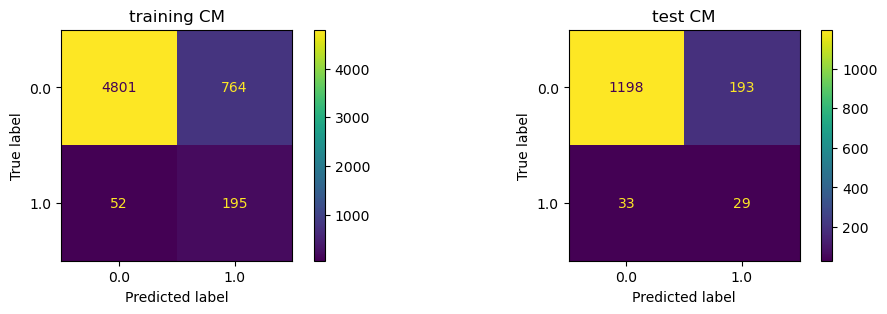

In [5]:
# plot the confusion matrices for training and test sets
fig, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
# confusion matrix of the training set as the second subplot
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_train,y_pred_train, ax=ax3)
# set the title for the subplot
ax3.title.set_text('training CM')
# confusion matrix of the test set as the third subplot
disp2 = metrics.ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test, ax=ax4)
ax4.title.set_text('test CM')

train ROC-AUC: 0.91
test ROC-AUC: 0.70
train PR-AUC: 0.54
test PR-AUC: 0.38


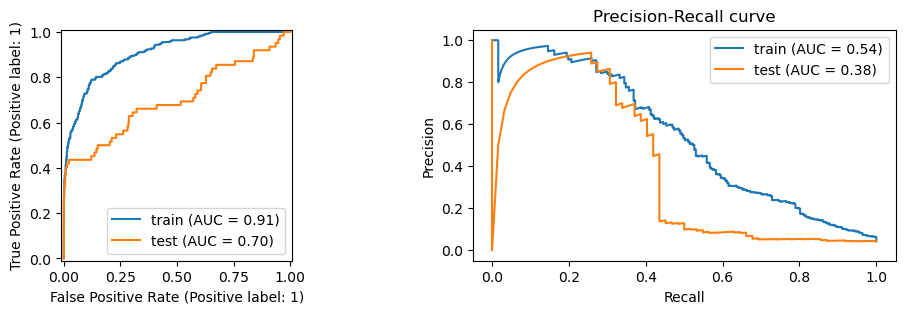

In [6]:
# create a figurespace with 3 subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

# ROC-AUC plots as the first subplot
y_train_prob = log_fit.predict_proba(X_train)[:,1]
print(f'train ROC-AUC: {metrics.roc_auc_score(y_train, y_train_prob):.2f}')
y_test_prob = log_fit.predict_proba(X_test)[:,1]
print(f'test ROC-AUC: {metrics.roc_auc_score(y_test, y_test_prob):.2f}')
metrics.RocCurveDisplay.from_predictions(y_train, y_train_prob, name="train", ax=ax1)
metrics.RocCurveDisplay.from_predictions(y_test,y_test_prob, name="test", ax=ax1)

precision_curve_train, recall_curve_train, _ = metrics.precision_recall_curve(y_train, y_train_prob)
print(f'train PR-AUC: {metrics.auc(recall_curve_train, precision_curve_train):.2f}')
precision_curve_test, recall_curve_test, _ = metrics.precision_recall_curve(y_test, y_test_prob)
print(f'test PR-AUC: {metrics.auc(recall_curve_test, precision_curve_test):.2f}')
# plot PR curves
ax2.plot(recall_curve_train, precision_curve_train, label='train (AUC = %0.2f)' % metrics.auc(recall_curve_train, precision_curve_train))
ax2.plot(recall_curve_test, precision_curve_test, label='test (AUC = %0.2f)' % metrics.auc(recall_curve_test, precision_curve_test))
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend()
ax2.title.set_text('Precision-Recall curve')

We now perform Hyperparameter tuning to look for the best hyperparameters. We first check the influence of $C$ using the default penalty (l2) and solver (lbfgs).

In [7]:
from sklearn.model_selection import GridSearchCV

# define the cross-validation method
cv = model_selection.StratifiedKFold(n_splits=5)

# define the hyperparameters to search
param_grid = {
    'C': [0.1, 0.5, 1, 2, 5],
}

grid_log = GridSearchCV(linear_model.LogisticRegression(max_iter=1000,class_weight='balanced'), param_grid, cv=cv)
grid_log.fit(X_train, y_train)

print("Best parameters found: ", grid_log.best_params_)
print("Best score found: ", grid_log.best_score_)
# retrieve the information
hyperparam_combi = grid_log.cv_results_['params']
C_test_score = grid_log.cv_results_['mean_test_score']
# print results for each model in the search
for i in range(len(hyperparam_combi)):
    print(f"Hyperparameters: {hyperparam_combi[i]} gave a score of {C_test_score[i]:.4f}")

Best parameters found:  {'C': 0.1}
Best score found:  0.8515187885801898
Hyperparameters: {'C': 0.1} gave a score of 0.8515
Hyperparameters: {'C': 0.5} gave a score of 0.8450
Hyperparameters: {'C': 1} gave a score of 0.8424
Hyperparameters: {'C': 2} gave a score of 0.8419
Hyperparameters: {'C': 5} gave a score of 0.8402


As can be seen, the influence of $C$ is small. We might want to consider using the sensitivity to optimize the parameters instead of the accuracy.

In [8]:
param_grid = {
    'C': [0.01, 0.1, 0.2, 0.5, 1, 2, 5],
}

grid_log = GridSearchCV(linear_model.LogisticRegression(max_iter=1000,class_weight='balanced'), param_grid, cv=cv, scoring='f1')
grid_log.fit(X_train, y_train)

print("Best parameters found: ", grid_log.best_params_)
print("Best score found: ", grid_log.best_score_)
# retrieve the information
hyperparam_combi = grid_log.cv_results_['params']
C_test_score = grid_log.cv_results_['mean_test_score']
# print results for each model in the search
for i in range(len(hyperparam_combi)):
    print(f"Hyperparameters: {hyperparam_combi[i]} gave a score of {C_test_score[i]:.4f}")

Best parameters found:  {'C': 0.01}
Best score found:  0.2763063722736142
Hyperparameters: {'C': 0.01} gave a score of 0.2763
Hyperparameters: {'C': 0.1} gave a score of 0.2573
Hyperparameters: {'C': 0.2} gave a score of 0.2553
Hyperparameters: {'C': 0.5} gave a score of 0.2489
Hyperparameters: {'C': 1} gave a score of 0.2446
Hyperparameters: {'C': 2} gave a score of 0.2441
Hyperparameters: {'C': 5} gave a score of 0.2400


       | accuracy | sensitivity | specificity | precision 
train  |   0.88   |     0.73    |    0.88     |   0.22
test   |   0.85   |     0.50    |    0.87     |   0.15

train F1-Score: 0.33
test F1-Score: 0.23
train ROC-AUC: 0.89
test ROC-AUC: 0.73
train PR-AUC: 0.53
test PR-AUC: 0.43


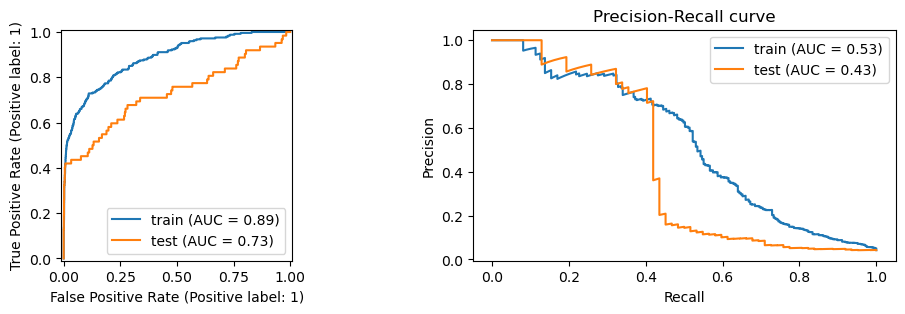

In [9]:
# Recalculate the prediction with the best hyperparameters
y_pred_train = grid_log.predict(X_train) # make predictions for the training set
y_pred_test = grid_log.predict(X_test) # make predictions for the test set

# Evaluate the model: calculate the evaluation metrics
acc_train = metrics.accuracy_score(y_train, y_pred_train)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
sens_train = metrics.recall_score(y_train, y_pred_train, pos_label=1)
sens_test = metrics.recall_score(y_test, y_pred_test, pos_label=1)
spec_train = metrics.recall_score(y_train, y_pred_train, pos_label=0)
spec_test = metrics.recall_score(y_test, y_pred_test, pos_label=0)
prec_train = metrics.precision_score(y_train, y_pred_train, pos_label=1)
prec_test = metrics.precision_score(y_test, y_pred_test, pos_label=1)

# print the evaluation metrics in a formatted manner
print("       | accuracy | sensitivity | specificity | precision ")
print(f"train  |   {acc_train:.2f}   |     {sens_train:.2f}    |    {spec_train:.2f}     |   {prec_train:.2f}")
print(f"test   |   {acc_test:.2f}   |     {sens_test:.2f}    |    {spec_test:.2f}     |   {prec_test:.2f}")

# calculate the F1-Score
precision_train, recall_train, f1_score_train, _ = metrics.precision_recall_fscore_support(y_train, y_pred_train, average='binary')
precision_test, recall_test, f1_score_test, _ = metrics.precision_recall_fscore_support(y_test, y_pred_test, average='binary')

print(f'\ntrain F1-Score: {f1_score_train:.2f}')
print(f'test F1-Score: {f1_score_test:.2f}')

# create a figurespace with 3 subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

# ROC-AUC plots as the first subplot
y_train_prob = grid_log.predict_proba(X_train)[:,1]
print(f'train ROC-AUC: {metrics.roc_auc_score(y_train, y_train_prob):.2f}')
y_test_prob = grid_log.predict_proba(X_test)[:,1]
print(f'test ROC-AUC: {metrics.roc_auc_score(y_test, y_test_prob):.2f}')
metrics.RocCurveDisplay.from_predictions(y_train, y_train_prob, name="train", ax=ax1)
metrics.RocCurveDisplay.from_predictions(y_test,y_test_prob, name="test", ax=ax1)

precision_curve_train, recall_curve_train, _ = metrics.precision_recall_curve(y_train, y_train_prob)
print(f'train PR-AUC: {metrics.auc(recall_curve_train, precision_curve_train):.2f}')
precision_curve_test, recall_curve_test, _ = metrics.precision_recall_curve(y_test, y_test_prob)
print(f'test PR-AUC: {metrics.auc(recall_curve_test, precision_curve_test):.2f}')
# plot PR curves
ax2.plot(recall_curve_train, precision_curve_train, label='train (AUC = %0.2f)' % metrics.auc(recall_curve_train, precision_curve_train))
ax2.plot(recall_curve_test, precision_curve_test, label='test (AUC = %0.2f)' % metrics.auc(recall_curve_test, precision_curve_test))
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend()
ax2.title.set_text('Precision-Recall curve')

The performance is virtually unchanged. We check how the scores vary when doing cross-validation using stratified k-fold to maintain class balance in each fold:

In [10]:
# Define a stratified k-fold cross-validation (to maintain class balance in each fold)
cv = model_selection.StratifiedKFold(n_splits=5)

# Custom scoring for F1, Precision, Recall, AUC-PR
scoring = {
    'precision': metrics.make_scorer(metrics.precision_score),
    'recall': metrics.make_scorer(metrics.recall_score),
    'f1': metrics.make_scorer(metrics.f1_score),
    'auc_pr': metrics.make_scorer(metrics.average_precision_score),  # For AUC-PR
    'roc_auc': 'roc_auc'  # For AUC-ROC
}

# Perform cross-validation and evaluate scores
cv_results = model_selection.cross_validate(grid_log, X_train, y_train, cv=cv, scoring=scoring)


for metric in scoring.keys():
    print(f"{metric}: {cv_results[f'test_{metric}']}")

for metric in scoring.keys():
    print(f"{metric}: {cv_results[f'test_{metric}'].mean():.2f} +/- {cv_results[f'test_{metric}'].std():.2f}")

precision: [0.15544041 0.15340909 0.21153846 0.17857143 0.20253165]
recall: [0.6        0.54       0.67346939 0.51020408 0.65306122]
f1: [0.24691358 0.23893805 0.32195122 0.26455026 0.30917874]
auc_pr: [0.11046115 0.10261735 0.15623404 0.11176192 0.14689551]
roc_auc: [0.75252471 0.73453729 0.77945248 0.77837065 0.84832316]
precision: 0.18 +/- 0.02
recall: 0.60 +/- 0.06
f1: 0.28 +/- 0.03
auc_pr: 0.13 +/- 0.02
roc_auc: 0.78 +/- 0.04
